<a href="https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/Clustering_Basado_en_prototipos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indice

[Volver al indice](https://colab.research.google.com/github/JDM-ULL-93/Practica_TID/blob/master/Indice.ipynb)

# **Paquetes necesarios**

*   **caret:** contiene funciones para entrenar y dibujar modelos de clasificación y regresión. Aunque para este modelo, solo lo usaremos para un balanceo  con **upSample**
*   **factoextra:** contiene funciones para extraer y visualizar la salida de diferentes análisis de datos multivariantes
*   **dplyr:** contiene funciones para la manipulación de datos tales como filtrado por filas, selección de columnas, reordenación de filas ...

















In [0]:
if (!requireNamespace("caret"))
  install.packages("caret")
library(caret)
if (!requireNamespace("factoextra"))
  install.packages("factoextra")
library(factoextra)
if (!requireNamespace("dplyr"))
  install.packages("dplyr")
library(dplyr)

# Carga y visualización de datos

Cargamos nuestro datasheet a memoria.Nuestro datasheet corresponde a un conjunto de datos normalizados y preprocesados (detección de valores nulos, eliminación parcial de outliers, analisis de componentes principales)  respecto al original. 

Nuestra base de datos se basa en las mediciones realizadas por 8 sensores sobre 8 músculos con una frecuencia de 200Hz , estas mediciones se hicieron 6 veces durante 20 segundos para cada gesto, por lo tanto:
* Tenemos un total de 64 columnas, cada una para cada sensor que mide cada musculo en cada movimiento, todas ellas de tipo float con valores dentro del rango **[-128.0,127.0]**. 
* Cada *487* filas corresponden a una de las 6 mediciones realizadas por 20 segundos para cada gesto. Este medición se hizo, de principio a fin,haciendo el mismo gesto, en una posición fija, sin transiciones de ningún tipo.
* Una última columna que representa el tipo de gesto al que se corresponde la medición:
```c#
Enum {
  Roca = 0,
  Tijeras = 1,
  Papel = 2,
  Ok = 3
}
```

El objetivo de nuestro tratamiento de datos es, con todas las variables de las que disponemos (excluyendo la clase) predecir el tipo de gesto que se ha realizado.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1.42838349,0.40170696,1.15012947,1.1730891,-0.04710804,-0.48219055,-4.293642,-4.24028809,-0.45983856,0.22415026,⋯,-1.7855609,3.3968017,0.39488063,1.7644141,0.7726201,0.2324183,-0.2592921,-2.2783569,1.0694782,0
2,-2.50338498,-0.44813614,-0.85390090,-0.8425861,0.73718804,-0.01724597,1.445703,-0.60602378,0.58850359,-0.28255256,⋯,-1.5876586,2.6277596,0.56147502,1.3619800,0.7726201,0.7368608,0.8365519,4.4517214,1.0050871,0
3,-0.99530940,-0.61810475,-1.45511001,-0.9769644,-1.16753100,-0.21097288,-3.097945,0.82172292,0.03674456,0.47750168,⋯,-5.4137702,0.4304965,0.64477221,0.3558947,-0.9878456,0.4005658,0.8365519,4.5704875,3.1299941,0
4,0.13574728,0.31672265,0.14811428,0.3668191,0.00891311,0.87389779,4.275519,-0.86561409,-0.84606988,-0.11365162,⋯,-2.4452353,-0.5582719,0.39488063,1.5631970,1.5851427,1.8578441,1.5410231,4.7684310,2.8080385,0
5,0.35118665,0.06176972,0.14811428,-0.1706943,-0.77538297,0.40895322,-1.981961,0.36743988,0.42297588,0.05524932,⋯,2.5682902,-1.8766298,-0.60468571,0.5571117,0.9080405,-0.7204175,-0.9246259,-4.3765578,-4.4037671,0
6,0.83592523,-0.36315183,-0.85390090,-1.9176128,0.68116689,-0.83089898,-1.463826,2.37926477,0.53332768,0.56195215,⋯,-1.6536260,0.3206333,0.56147502,1.3619800,1.5851427,0.2884675,1.1887875,-1.8428813,1.6489983,0
7,-0.61829051,-0.36315183,-0.05228875,0.6355757,-0.88742526,-0.63717207,-2.699379,-0.99540924,-0.62536627,-0.19810209,⋯,0.1274949,-1.9315614,-0.77128010,-2.2599270,-2.0712090,-0.6643683,-1.8247835,0.2949083,-1.8925134,0
8,2.34400081,0.06176972,-0.25269179,0.9043324,0.62514574,1.02887931,2.083408,1.79518657,-0.45983856,-0.11365162,⋯,2.7661925,0.8699491,0.39488063,2.1668482,3.4810288,0.5126641,0.5234537,2.9473510,3.0656030,0
9,-1.80320704,0.31672265,1.95174161,3.9950344,0.34504000,-0.94713512,-4.891490,-0.02194558,0.69885539,-0.45145350,⋯,-0.3342772,2.2981702,0.06169185,-1.8574929,-2.2066295,1.1852541,0.1320808,1.7201014,0.7475226,0


       V1                  V2                 V3                  V4          
 Min.   :-5.411816   Min.   :-8.77660   Min.   :-6.465186   Min.   :-8.63653  
 1st Qu.:-0.456711   1st Qu.:-0.27817   1st Qu.:-0.453095   1st Qu.:-0.43945  
 Median :-0.025832   Median :-0.02321   Median :-0.052289   Median :-0.03632  
 Mean   :-0.000584   Mean   :-0.00182   Mean   : 0.005197   Mean   : 0.01625  
 3rd Qu.: 0.351187   3rd Qu.: 0.31672   3rd Qu.: 0.548920   3rd Qu.: 0.36682  
 Max.   : 6.006470   Max.   : 7.28544   Max.   : 6.160205   Max.   : 5.74195  
       V5                  V6                 V7                 V8          
 Min.   :-5.593202   Min.   :-4.39547   Min.   :-5.05092   Min.   :-8.26394  
 1st Qu.:-0.551298   1st Qu.:-0.52094   1st Qu.:-0.14856   1st Qu.:-0.41133  
 Median : 0.008913   Median :-0.01725   Median : 0.01087   Median :-0.02195  
 Mean   :-0.002763   Mean   :-0.00144   Mean   : 0.01616   Mean   : 0.01074  
 3rd Qu.: 0.569125   3rd Qu.: 0.52519   3rd Qu.: 0.17029 

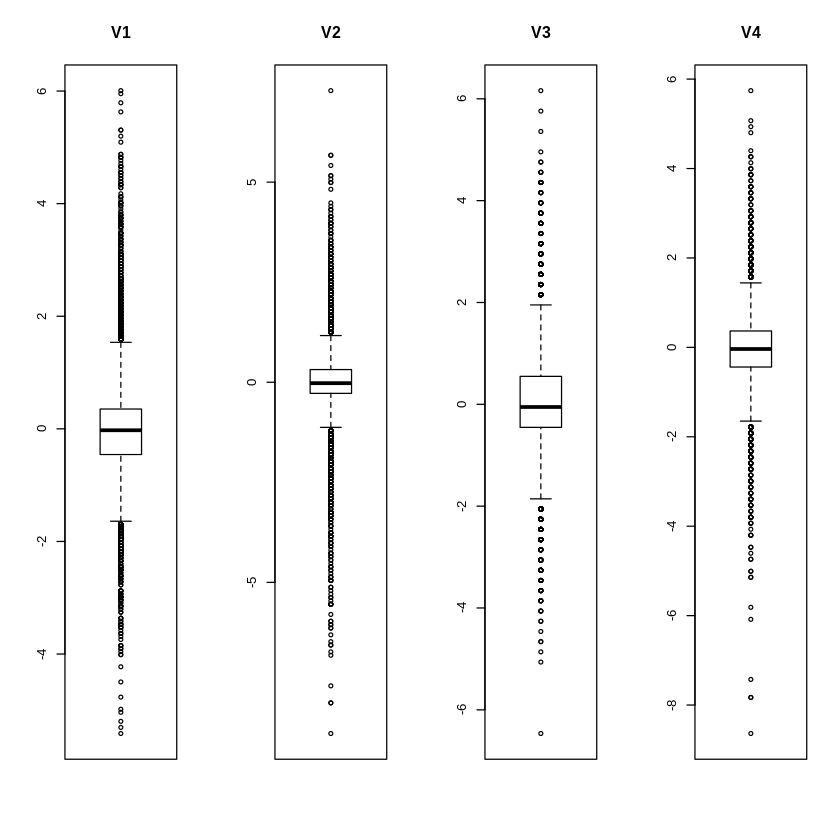

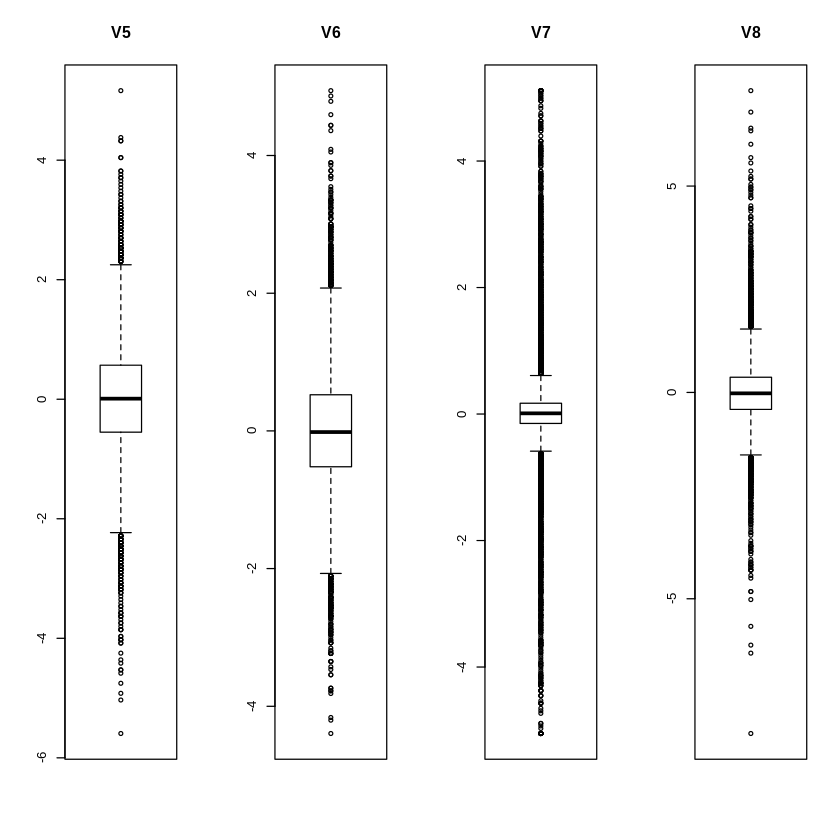

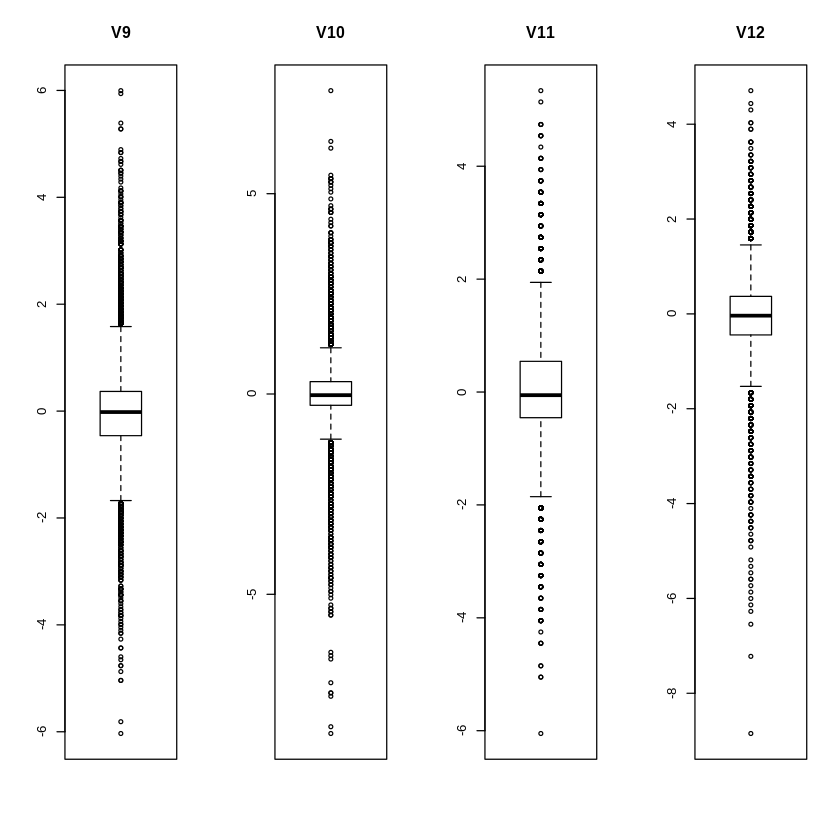

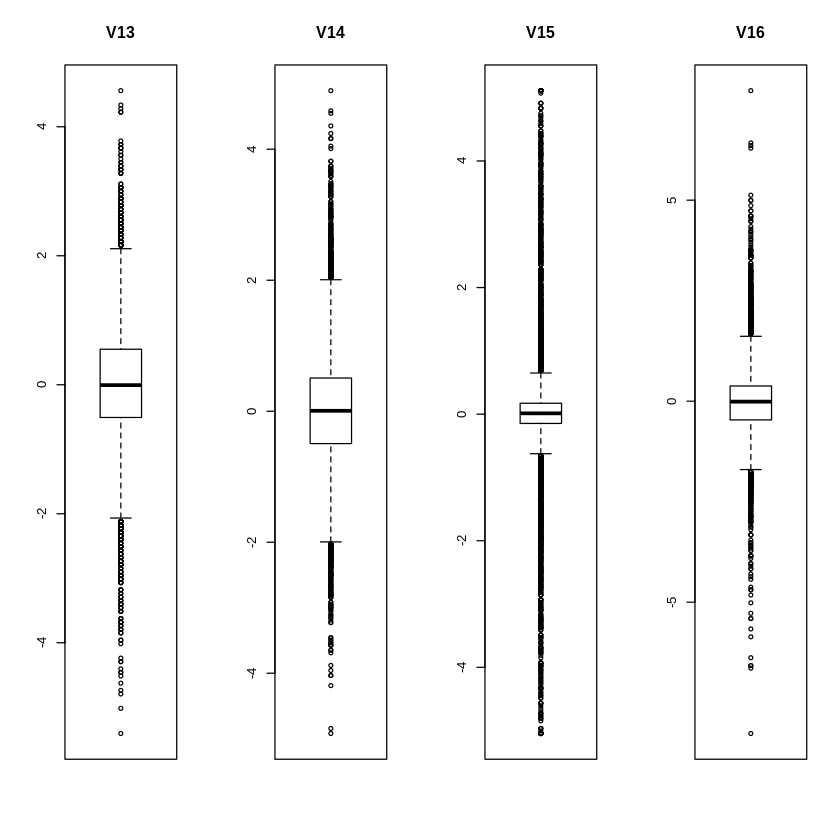

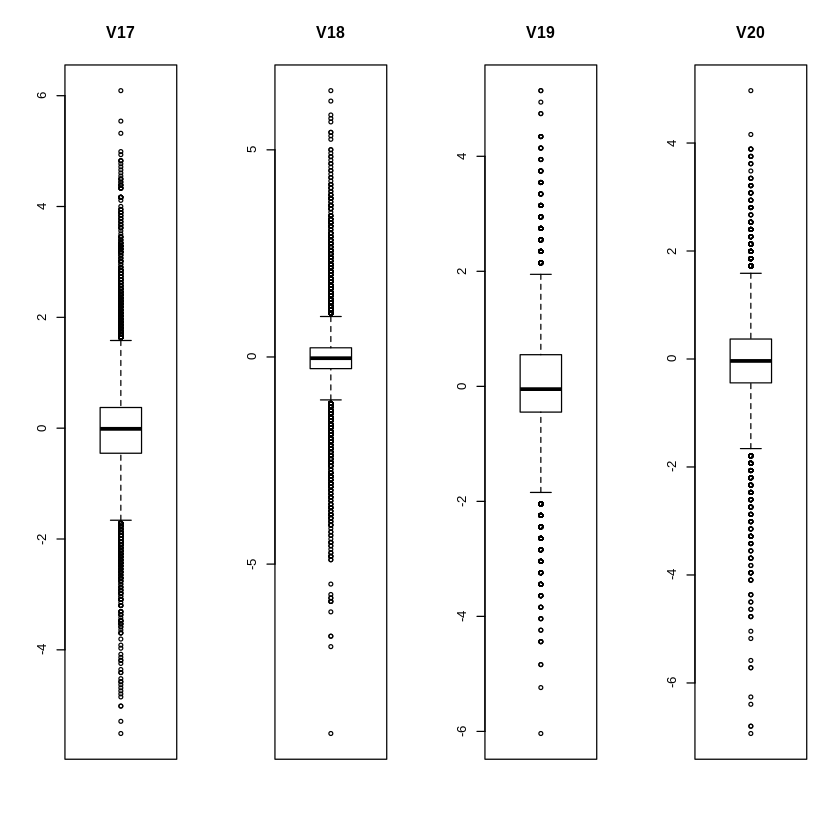

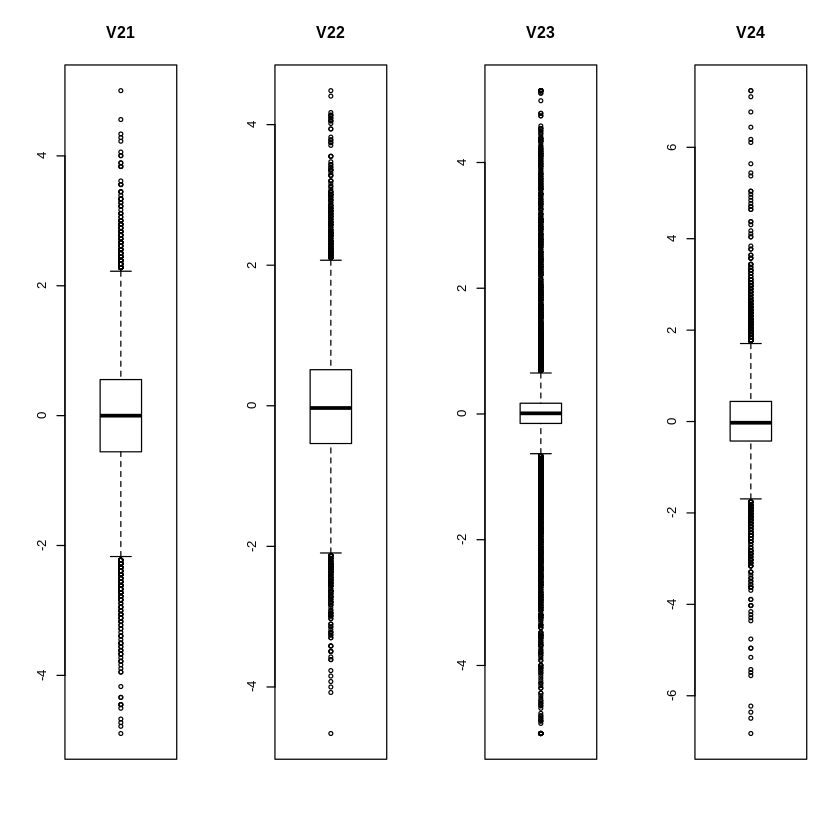

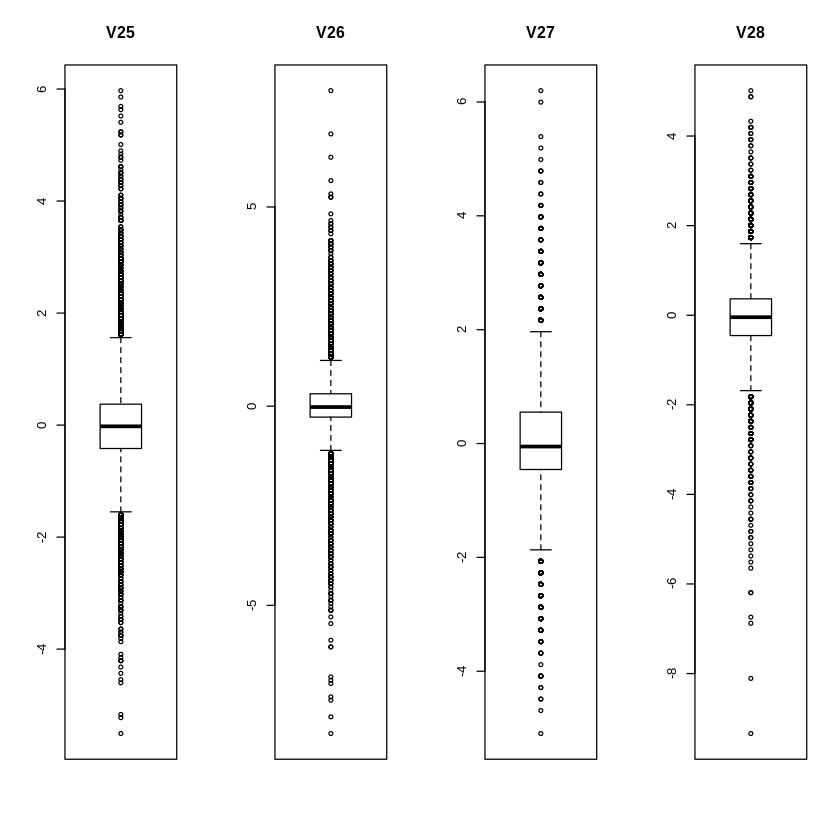

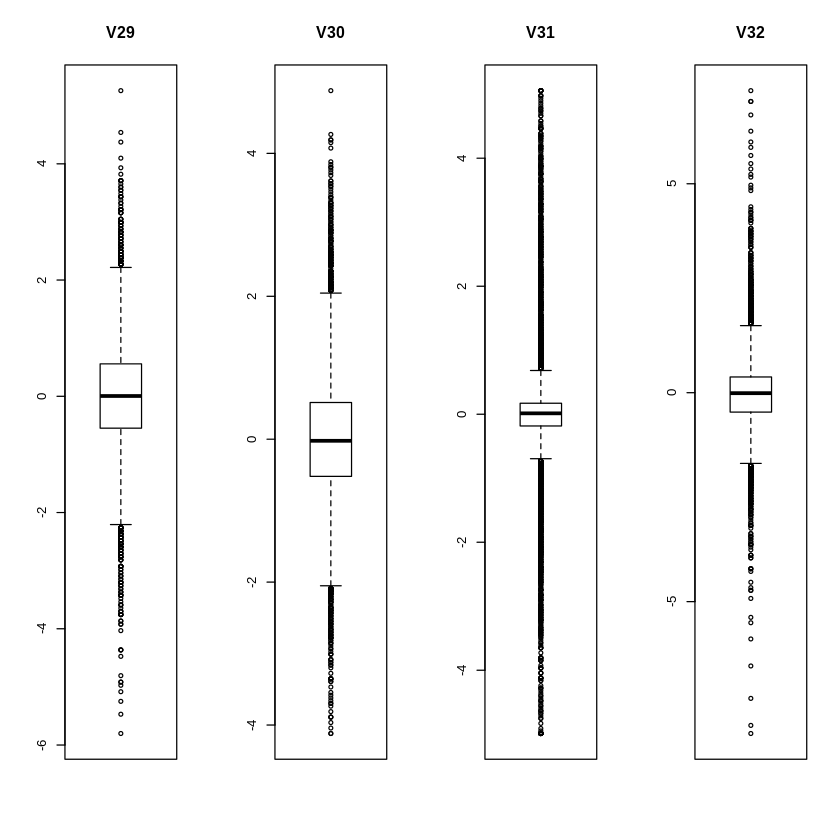

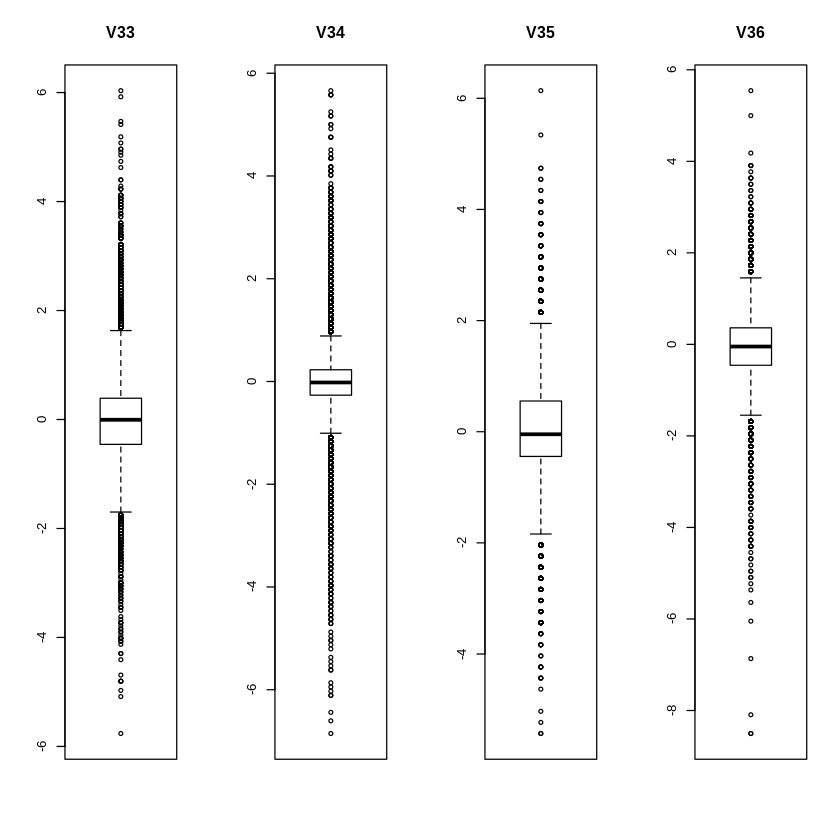

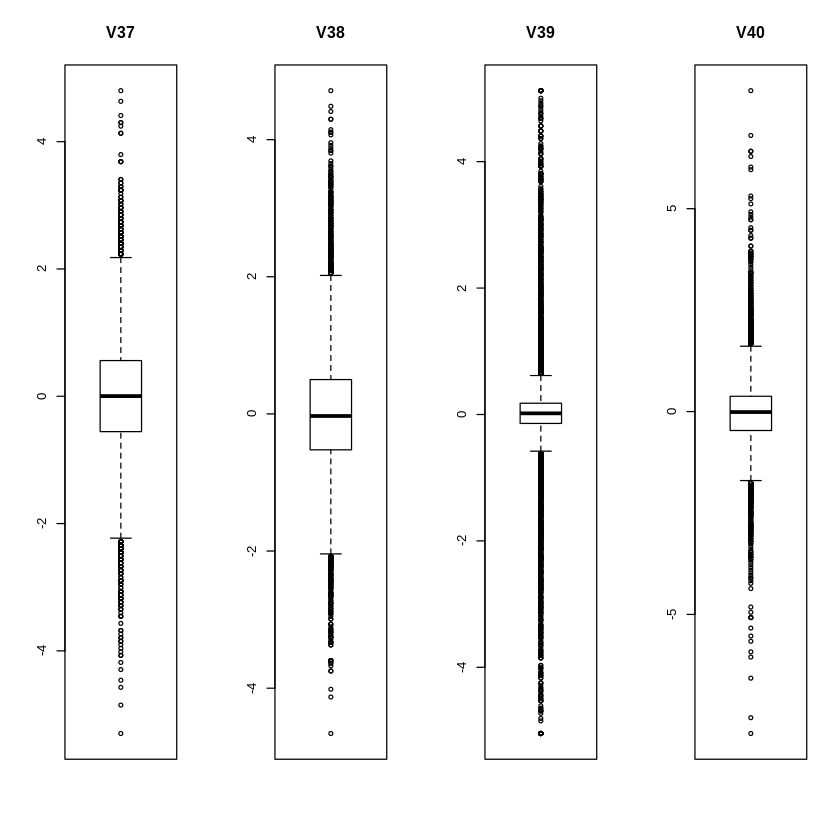

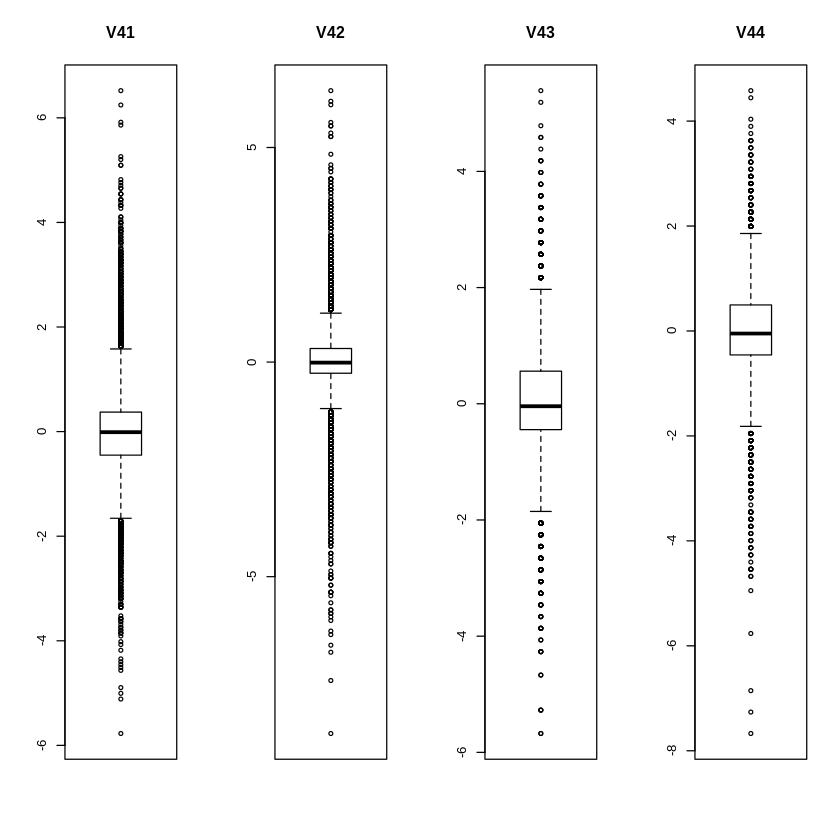

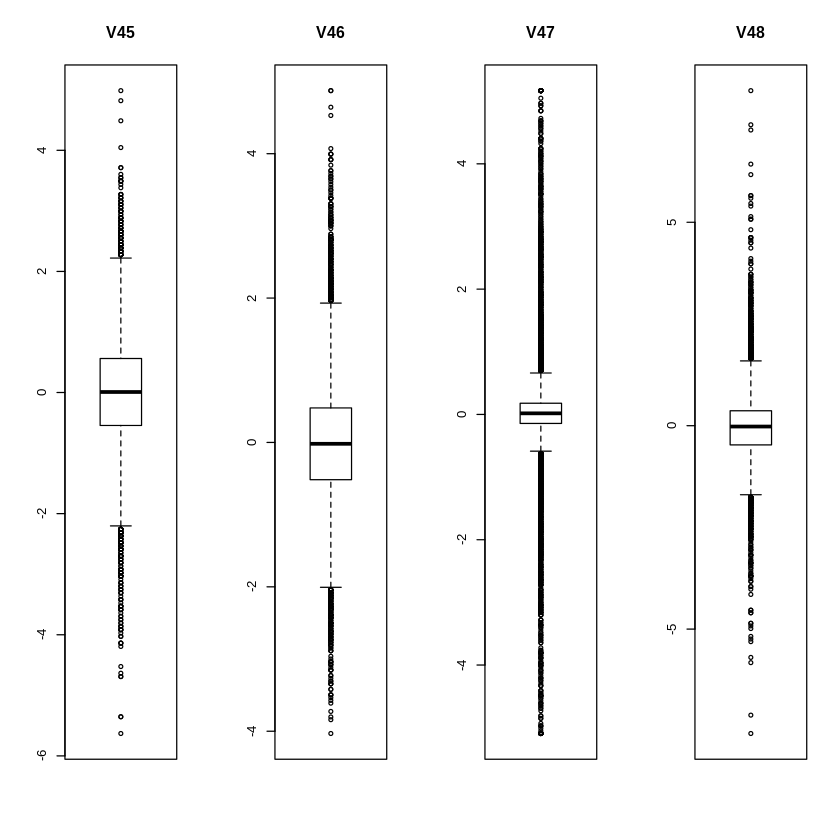

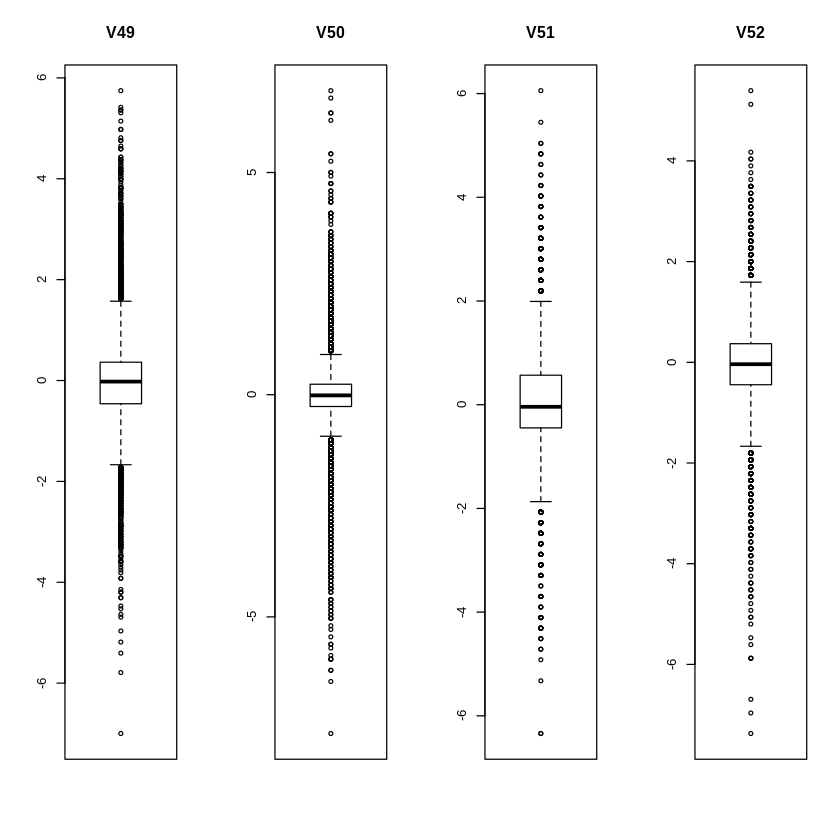

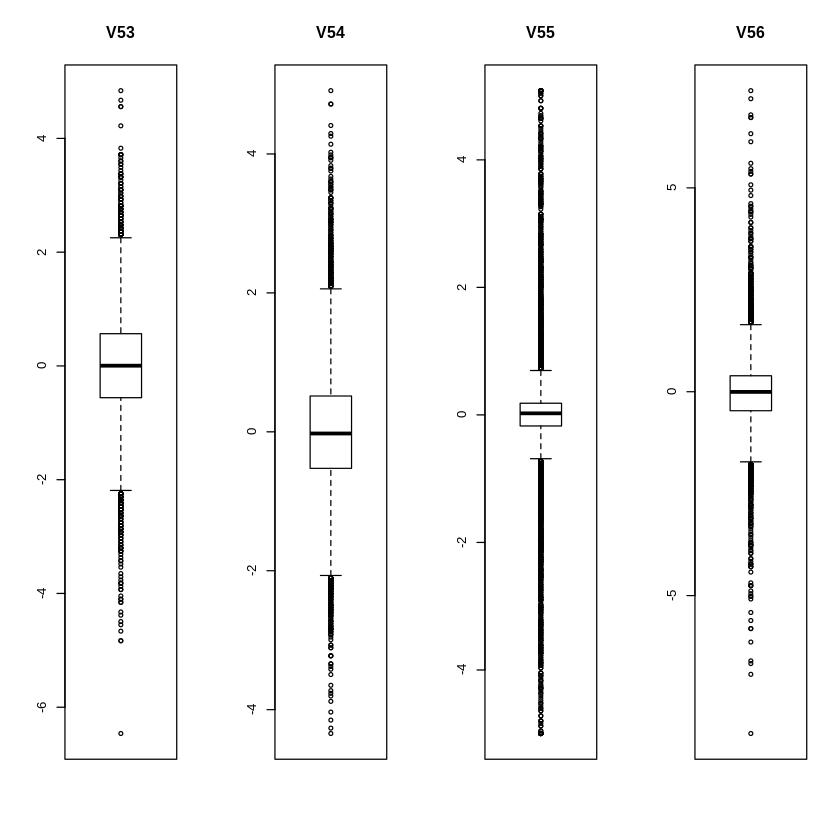

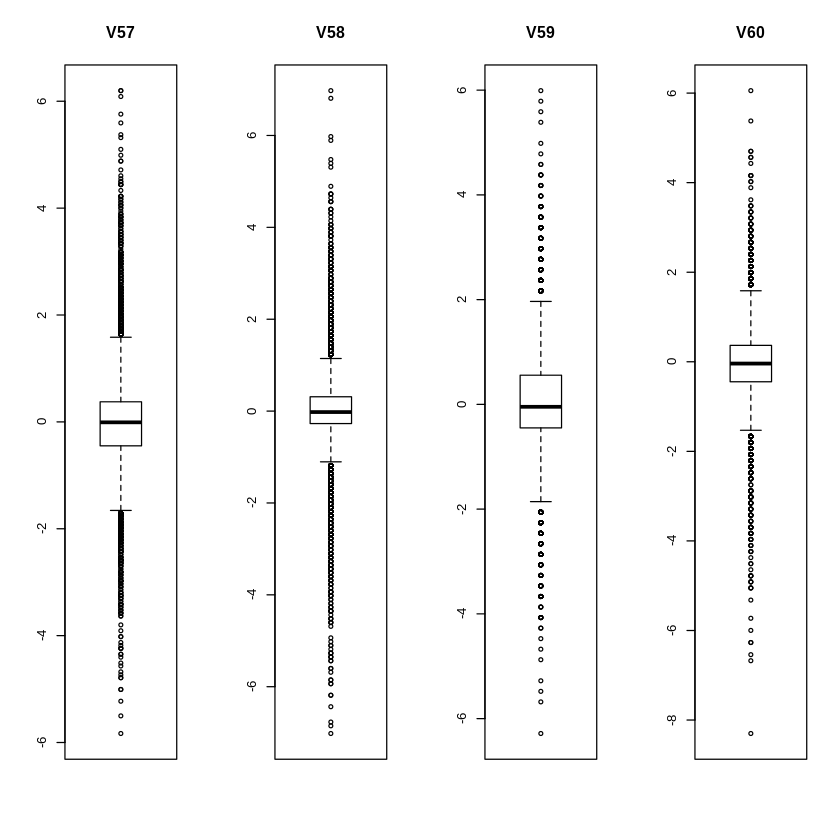

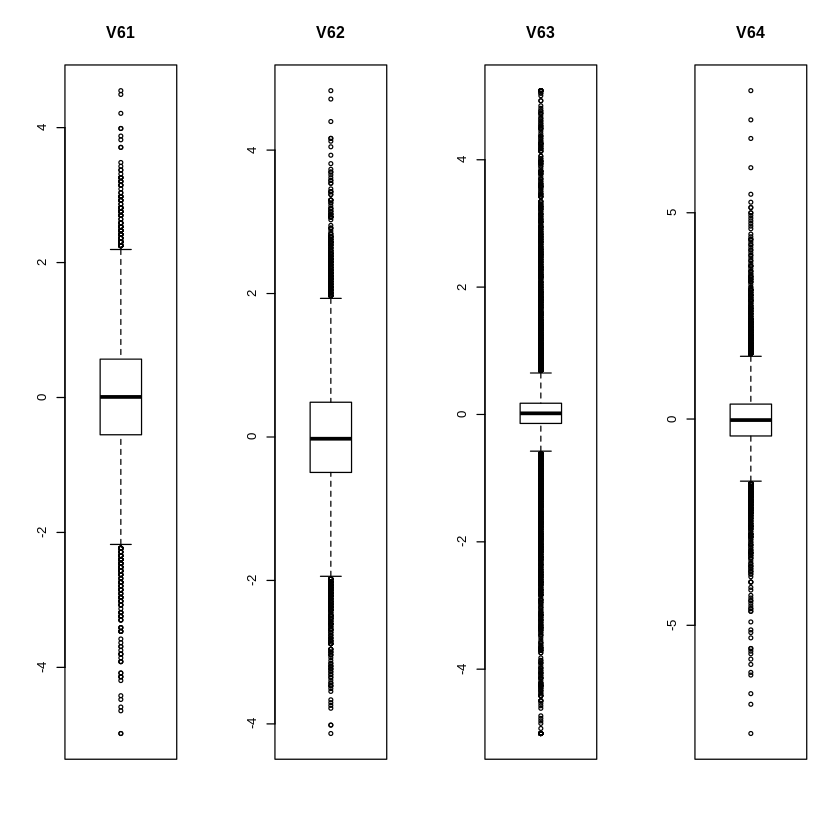

In [0]:
#Cargamos nuestros datos
#data = read.csv("/content/all.csv",header=FALSE, sep=",")
#data = read.csv("https://uc36943bfd09a58be3b54c0ce836.dl.dropboxusercontent.com/cd/0/get/A4R6OXi1GuzkFsDQE41Vj1vo8nvN3gCH8OnA41L9RZdmTUZZSz4sb7MCkkpfc1SyR9V27bcczlCjvpBJDLukItZXb1kPtwTT4PwGwNaCEL1i4ytv9tiHrGZSXI10waPGzIc/file#", header=FALSE, sep = ",")
data = read.csv("/content/cleanedAll.csv",header=FALSE, sep=",")
head(data, 10)

data$V65 <- as.factor(data$V65)
summary(data)

par(mfrow=c(1,4))
for(i in 1:64) {
  boxplot(data[,i], main=names(data)[i])
}


#Preprocesamiento de datos

Ya hicimos un preprocesado de datos , pero todavía faltaría dividir nuestros datos en 2 conjuntos, uno de entrenamiento y otro de validación, de forma que el primero sirva para crear el modelo y el segundo pueda servir para probar el modelo frente al mundo real, detectando la precisión del modelo o el posible sobreajuste de este.

In [0]:
set.seed(56)
data.entrenamiento <- sample_frac(data, 0.5) #Bajado de 0.7 a 0.5 para evitar sobreajustes
data.validacion <- setdiff(data, data.entrenamiento)

#Ejecutamos un upperSample en conjunto de entrenamiento para balancear clases
print("Antes de balanceo upperSample :")
summary(data.entrenamiento$V65)
data.entrenamiento <- upSample(data.entrenamiento, data.entrenamiento$V65)
print("Despues de balanceo upperSample :")
summary(data.entrenamiento$V65)




[1] "Antes de balanceo upperSample :"


0    1    2    3 
1315 1330 1389 1194

[1] "Despues de balanceo upperSample :"


0    1    2    3 
1389 1389 1389 1389

# **Análisis** Obtención del clustering Jerarquico

Vamos a obtener nuestro clustering jerarquico utilizando el algoritmo K-Means.

Dado que tenemos 64 variables y el algoritmo K-Means solo trabaja en 2 dimensiones, vamos a hacer permutación de 2 con cada columna, y seleccionamos la mejor combinación


In [0]:
data.predictores <- select(data, num_range("V", 1:64))

In [0]:
#WARNING: El siguiente algoritmo tarda su tiempo
if(FALSE){ #DESCOMENTAR o cambiar a TRUE
bestKMeans = 0
dfmine = 0
bestInformation = 0
bestCombinationX = ""
bestCombinationY = ""
for (i in colnames(data.predictores)){
  for( j in colnames(data.predictores)){
    if(i != j){
      dfmine <- select(data.predictores,i,j)
      res <- kmeans(dfmine, centers = 4, nstart = 20)
      if(res$betweenss/res$totss > bestInformation){
        bestKMeans = res
        bestInformation = res$betweenss/res$totss
        bestCombinationX = i
        bestCombinationY = j
      }
      if(bestInformation >= 0.9) break
    }
    if(bestInformation >= 0.9) break
  }
}
print(bestInformation)
print(bestCombinationX)
print(bestCombinationY)
}else{ #Para ahorrar tiempo, el resultado siguiente es lo mismo que lo que se calcula previamente
  print("0.6483182")
  print("V22")
  print("V21")
  dfmine <- select(data.predictores,"V22","V21")
  bestKMeans  <- kmeans(dfmine, centers = 4, nstart = 20)
}


[1] "0.6483182"
[1] "V22"
[1] "V21"


Con los campos más optimos seleccionados, visualizamos los clusteres reales y los clusteres generados con el algoritmo K-Means

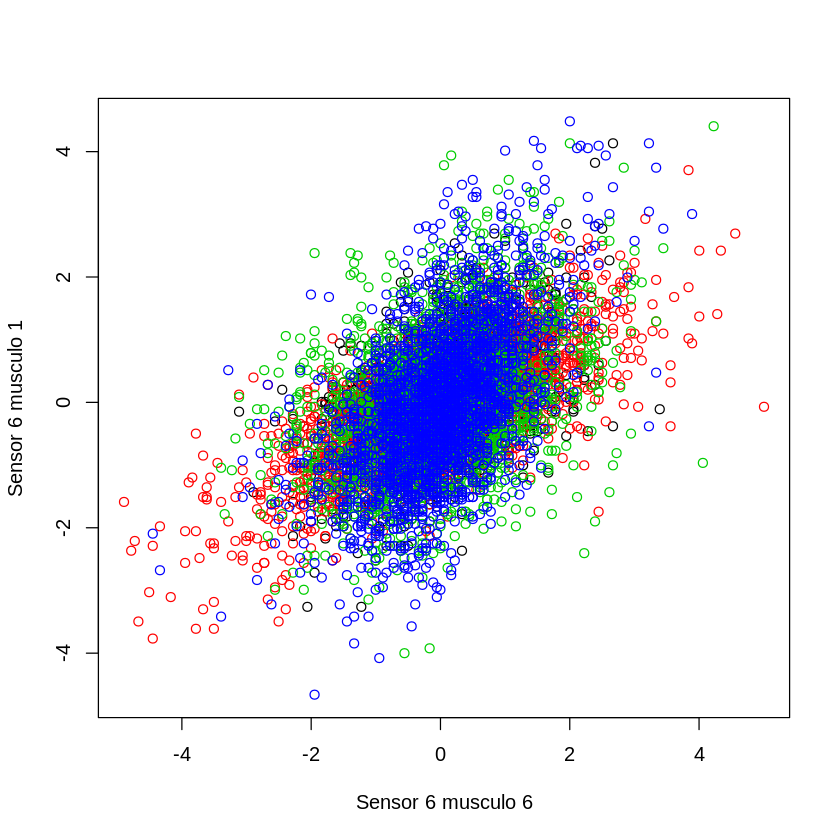

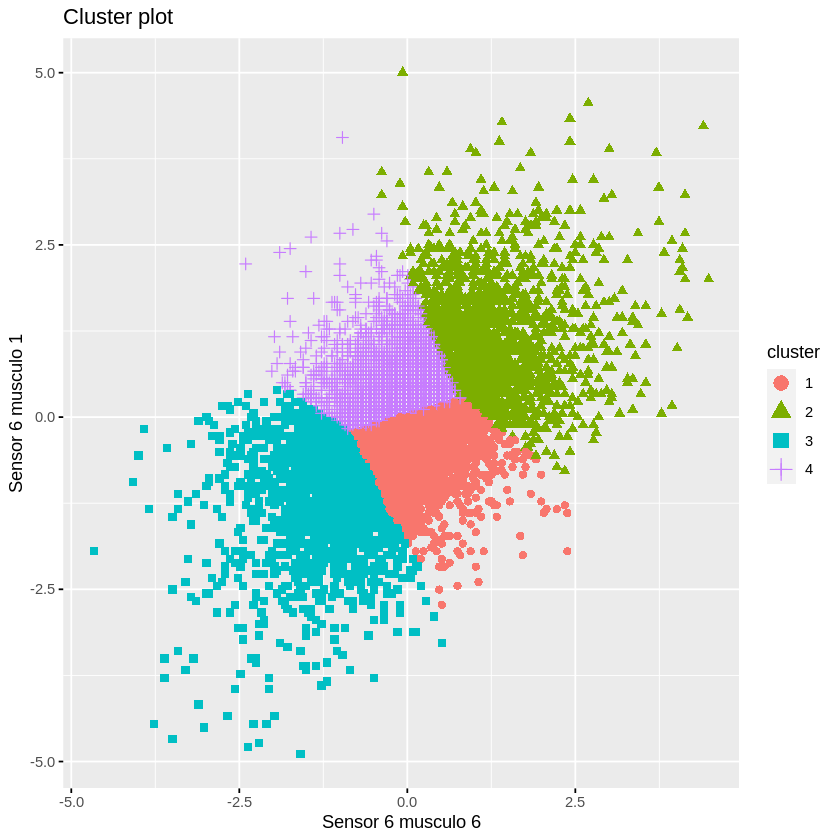

In [0]:
plot(data$V22 ~ data$V21, col = data$V65, pch = 1, ylab = "Sensor 6 musculo 1", xlab = "Sensor 6 musculo 6" )
fviz_cluster(bestKMeans, dfmine, geom = "point", ellipse = FALSE, pointsize = 2, ylab = "Sensor 6 musculo 1", xlab = "Sensor 6 musculo 6", stand = FALSE)

Podemos ver que el algoritmo hace lo que puede. Dado que se trata en un algoritmo basado sobretodo en calculo de centroides, es incapaz de imitar la naturaleza real de los datos, sobretodo porque nuestros datos tiene una enorme cantidad de outliers que no pueden ser eliminados. Clusterizar nuestros datos, con un algoritmo K-Means se antoja muy dificil. Sin embargo, con lo poco que podemos hacer, podemos mejorar nuestros resultados

#**Análisis** Obtener el nº optimo de K para algoritmo K-Means optimo 



Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


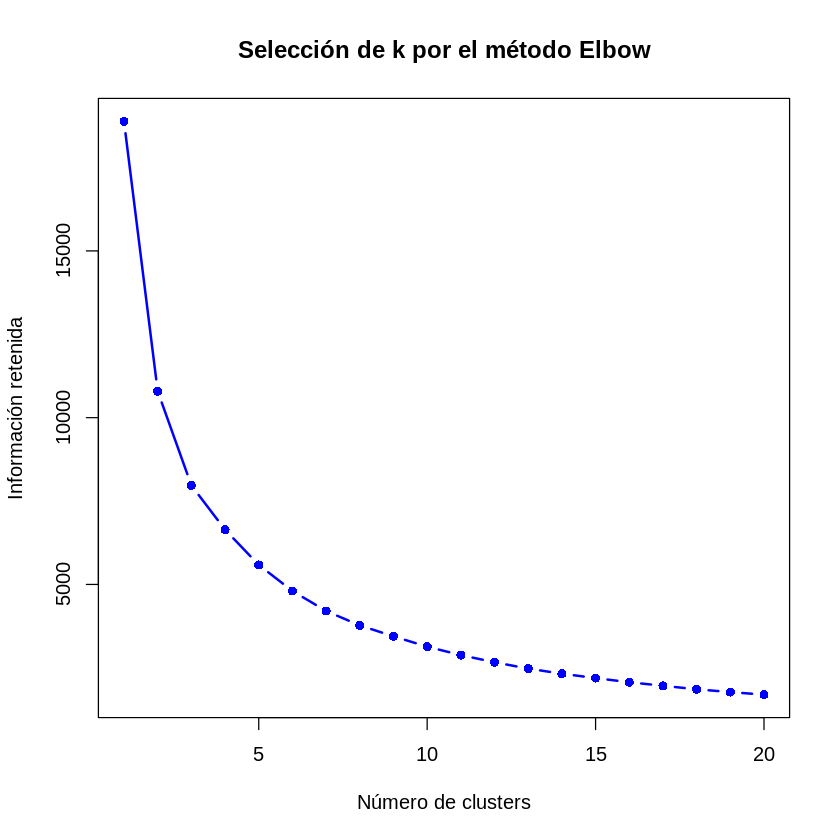

In [0]:
information <- rep(0, 20)
for (i in 1:20){
   KM = kmeans(dfmine, i, nstart = 20)
   information[i] = KM$tot.withinss
}
plot(information~seq(1:20), type="b", pch=16, col=4, ylab="Información retenida", lwd = 2,
     xlab="Número de clusters", main="Selección de k por el método Elbow")

De la grafica anterior podemos decir que el número optimo se encuentra entre 4 y 5 clusteres



Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 522750)”


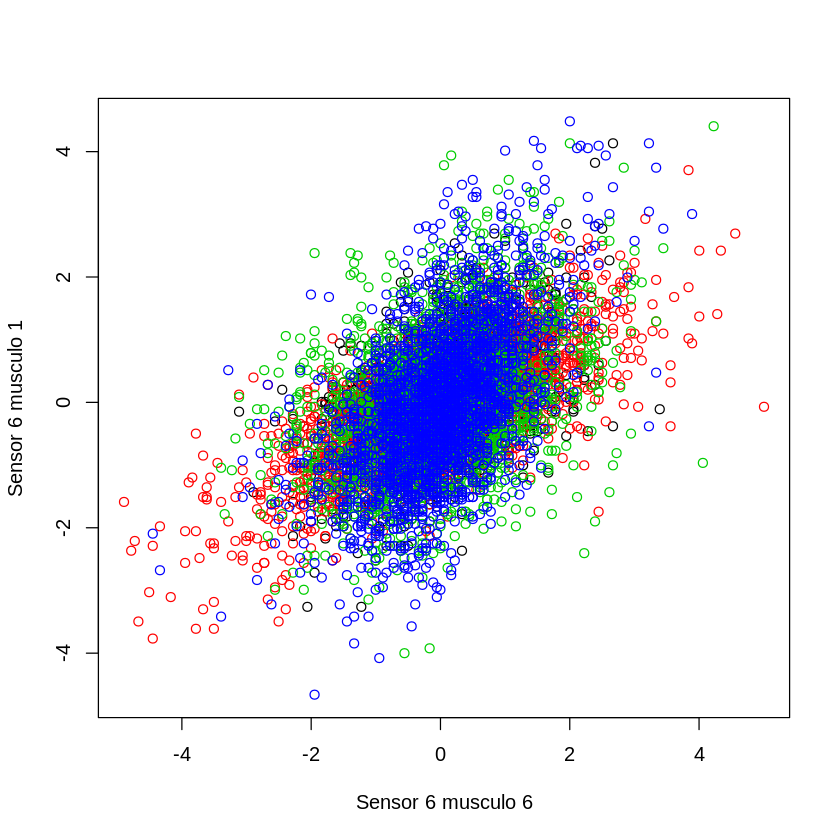

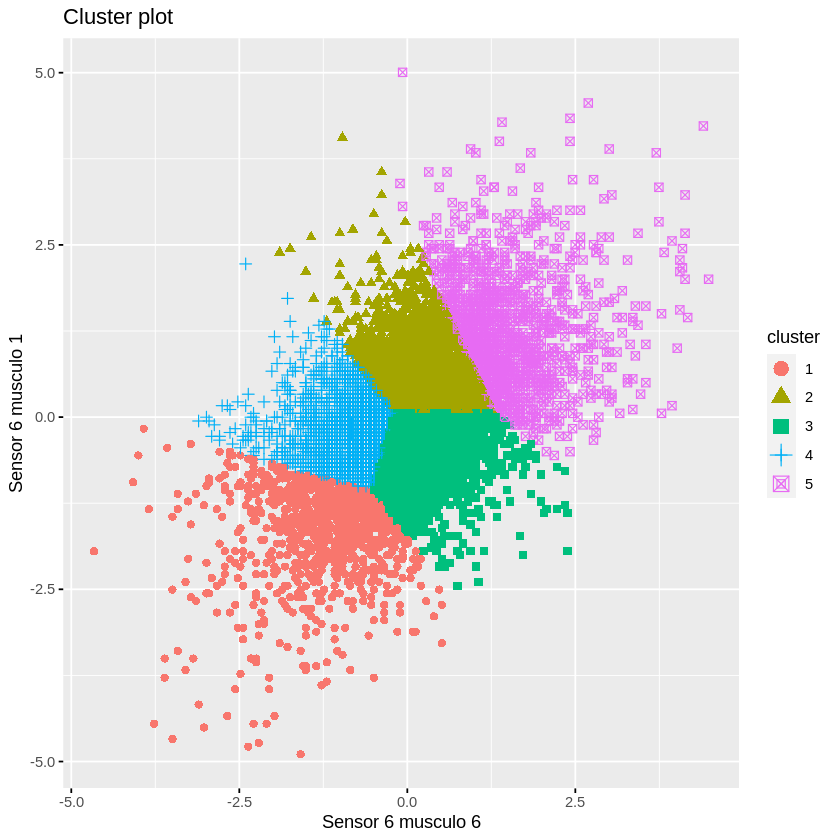

In [0]:
dfmine <- select(data.predictores,"V22","V21")
bestKMeans  <- kmeans(dfmine, centers = 5, nstart = 20)
plot(data$V22 ~ data$V21, col = data$V65, pch = 1, ylab = "Sensor 6 musculo 1", xlab = "Sensor 6 musculo 6" )
fviz_cluster(bestKMeans, dfmine, geom = "point", ellipse = FALSE, pointsize = 2, ylab = "Sensor 6 musculo 1", xlab = "Sensor 6 musculo 6", stand = FALSE)